We simulate estimating the fraction of maize area in Iowa in 2022. To probe the effect of map product noise and bias on different methods, we artificially degrade the map product quality relative to simulated “ground truth” points. 

For this simulation, we use the USDA’s Cropland Data Layer (CDL) as the ground truth for crop types in Iowa. We sample N = 100000 locations uniformly at random from a binary maize/non-maize map derived from CDL. In each trial, we sample n = 100 “ground truth” points uniformly at random from the N = 100000 map product points. We systematically add noise or bias to the map product points while keeping the ground truth points constant, and then compare our maize fraction estimates across map-only, classical, post-stratified, and PPI estimators.

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from ppi_py import ppi_mean_ci, classical_mean_ci
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import _zconfint_generic, _zstat_generic

# Load the data (100k map product points)

Each pixel is labeled 0 if non-maize and 1 if maize. 

In [2]:
# Map product points from USDA NASS CDL: https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL
data = pd.read_csv('data/iowa_crop_labels_100k.csv')

In [3]:
data["Ground Truth Corn 2022"] = data['cropland'].apply(lambda x: 1 if x==1 else 0)

We compute the "true" mean maize value from all 100k map product points, which is about 0.35.

In [4]:
Y_total = np.array(data["Ground Truth Corn 2022"])

# True mean (computed on all labels)
true_theta = Y_total.mean()
print(true_theta)

0.35155


# Methods

We will compute maize fraction 95% confidence interval estimates across map-only, classical, post-stratified, and PPI estimators. (Note that the post-stratified interval is equivalent to stratified mean estimation where the map product predictions are treated as the strata labels.)

Stratified mean estimation confidence interval code:

In [5]:
# Stratified mean estimation confidence interval

def stratified_mean_ci(strata_to_weights, Y, Y_strata, alpha, alternative="two-sided"):
    mean = 0
    squared_se = 0
    for stratum, weight in strata_to_weights.items():
        Y_stratum = Y[Y_strata==stratum]
        n = Y_stratum.shape[0]
        mean += weight*Y_stratum.mean()
        squared_se += (weight**2)*Y_stratum.var()/n
    return _zconfint_generic(
        mean, np.sqrt(squared_se), alpha, alternative
    )

In [6]:
def run_ppi(Y_total, Yhat_total, ns, num_trials, alpha):
    results = []
    n_total = Y_total.shape[0]
    strata_to_weights = {0:1-Yhat_total.mean(), 1:Yhat_total.mean()}
    
    for i in tqdm(range(ns.shape[0])):
        for j in range(num_trials):
            # Prediction-Powered Inference
            n = ns[i]
            rand_idx = np.random.RandomState(seed=j).permutation(n_total)
            _Yhat = Yhat_total[rand_idx[:n]]
            _Y = Y_total[rand_idx[:n]]
            _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

            ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

            # Classical interval
            classical_ci = classical_mean_ci(_Y, alpha=alpha)
            
            # Post-stratified interval (equivalent to stratified where Yhat are the strata labels)
            post_stratified_ci = stratified_mean_ci(strata_to_weights, _Y, _Yhat, alpha=alpha)

            # Append results
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "PPI",
                            "n": n,
                            "lower": ppi_ci[0],
                            "upper": ppi_ci[1],
                            "trial": j,
                        }
                    ]
                )
            ]
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "Classical",
                            "n": n,
                            "lower": classical_ci[0],
                            "upper": classical_ci[1],
                            "trial": j,
                        }
                    ]
                )
            ]
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "Post-stratified",
                            "n": n,
                            "lower": post_stratified_ci[0],
                            "upper": post_stratified_ci[1],
                            "trial": j,
                        }
                    ]
                )
            ]

    # Map-only CI
    map_only_ci = classical_mean_ci(Yhat_total, alpha=alpha)
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Map-only",
                    "n": np.nan,
                    "lower": map_only_ci[0],
                    "upper": map_only_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]
    df["estimate"] = 0.5*(df["upper"] + df["lower"])
    return df

# Experiments: Adding Noise

We define adding unbiased noise at level p to the map product as resampling
each of the 100000 map product points with probability p from the Bernoulli(0.35) distribution. In other
words, about p fraction of the points are randomly labeled, while the remaining 1 − p points are unchanged.
Each resampled point is labeled as maize with probability 0.35 and non-maize with probability 0.65. We
experiment with noise probabilities p from 0 to 1 at increments of 0.1.

We also compute the map model accuracy (fraction of map product points whose values remain correct) at each noise probability.

We compute the confidence intervals and average over 100 trials, where n=100 ground truth points are randomly chosen on each trial. 

In [7]:
# Add noise to ML model (resample with probability p, from Bernoulli(true_theta) distribution)
probabilities = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
model_accuracies = []
ppi_avg_estimates = []
ppi_avg_widths = []
post_stratified_avg_estimates = []
post_stratified_avg_widths = []
map_only_estimates = []
map_only_widths = []

for p in probabilities:
    noise_mask = np.array(np.random.RandomState(seed=42).choice([0,1], p=[1-p, p], size = Y_total.shape[0]))
    random_labels = np.array(np.random.RandomState(seed=int(10*p)).choice([0, 1], p=[1-true_theta, true_theta], size=Y_total.shape[0]))
    noisy_Yhat_total = Y_total*(1-noise_mask) + random_labels*noise_mask
    model_accuracy = (Y_total==noisy_Yhat_total).sum() / Y_total.size
    model_accuracies.append(model_accuracy)

    df = run_ppi(Y_total, noisy_Yhat_total, ns=np.array([100]), num_trials=100, alpha=0.05)

    ppi_results = df.loc[(df['method'] == 'PPI') & (df['n'] == 100)]
    ppi_avg_estimates.append(ppi_results['estimate'].mean())
    ppi_avg_widths.append(ppi_results['width'].mean())
    
    post_stratified_results = df.loc[(df['method'] == 'Post-stratified') & (df['n'] == 100)]
    post_stratified_avg_estimates.append(post_stratified_results['estimate'].mean())
    post_stratified_avg_widths.append(post_stratified_results['width'].mean())
    
    classical_results = df.loc[(df['method'] == 'Classical') & (df['n'] == 100)]
    classical_avg_estimate = classical_results['estimate'].mean()
    classical_avg_width = classical_results['width'].mean()
    
    map_only_estimates.append(df.loc[df['method']=='Map-only']['estimate'].mean())
    map_only_widths.append(df.loc[df['method']=='Map-only']['width'].mean())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


In [8]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=10)          
plt.rc('axes', titlesize=22)     
plt.rc('axes', labelsize=18)    
plt.rc('xtick', labelsize=14)    
plt.rc('ytick', labelsize=14)    
plt.rc('legend', fontsize=13)    
plt.rc('figure', titlesize=22)

Visualize estimated maize fraction at different noise levels

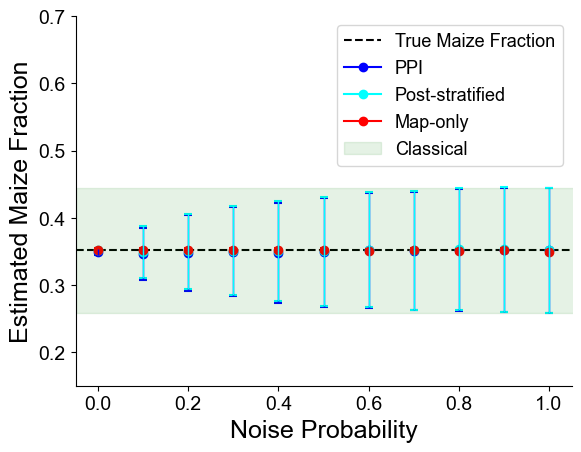

In [9]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Post-stratified')
plt.plot([], '-o', color='red', label='Map-only')

plt.scatter(probabilities, ppi_avg_estimates, color='blue')
plt.scatter(probabilities, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(probabilities, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(probabilities, post_stratified_avg_estimates, color='cyan')
plt.scatter(probabilities, post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
plt.scatter(probabilities, post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2)[i]
    ymax = (post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(probabilities, map_only_estimates, color='red')
plt.scatter(probabilities, map_only_estimates-np.array(map_only_widths)/2, color='red', marker='_')
plt.scatter(probabilities, map_only_estimates+np.array(map_only_widths)/2, color='red', marker='_')


plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.legend()
plt.xlim([-0.05, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Noise Probability")
plt.savefig('output_images/corn_fraction_noise.png', dpi=300, bbox_inches='tight')
plt.show()

Visualize estimated maize fraction at different model accuracies (from varying noise level)

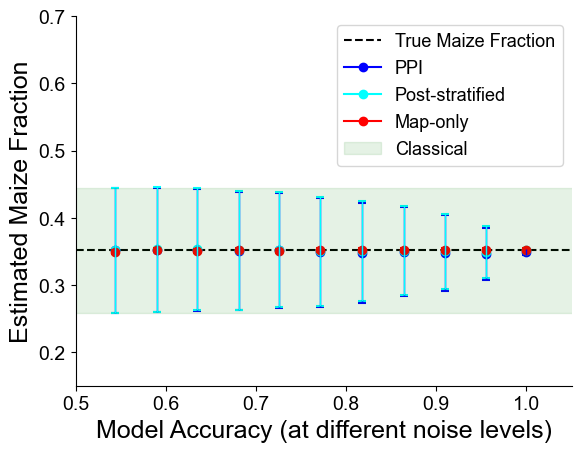

In [10]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Post-stratified')
plt.plot([], '-o', color='red', label='Map-only')

plt.scatter(model_accuracies, ppi_avg_estimates, color='blue')
plt.scatter(model_accuracies, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(model_accuracies, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(model_accuracies, post_stratified_avg_estimates, color='cyan')
plt.scatter(model_accuracies, post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
plt.scatter(model_accuracies, post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2)[i]
    ymax = (post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(model_accuracies, map_only_estimates, color='red')
plt.scatter(model_accuracies, map_only_estimates-np.array(map_only_widths)/2, color='red', marker='_')
plt.scatter(model_accuracies, map_only_estimates+np.array(map_only_widths)/2, color='red', marker='_')


plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.legend()
plt.xlim([0.5, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Model Accuracy (at different noise levels)")
plt.savefig('output_images/corn_fraction_noise_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

Visualize effective sample size at different noise levels

C:\Users\Kerri\AppData\Local\Temp\ipykernel_7872\2088229519.py:8: RuntimeWarning: divide by zero encountered in divide
  post_stratified_effective_sample_sizes = 100*(classical_avg_width**2)/(np.array(post_stratified_avg_widths)**2)


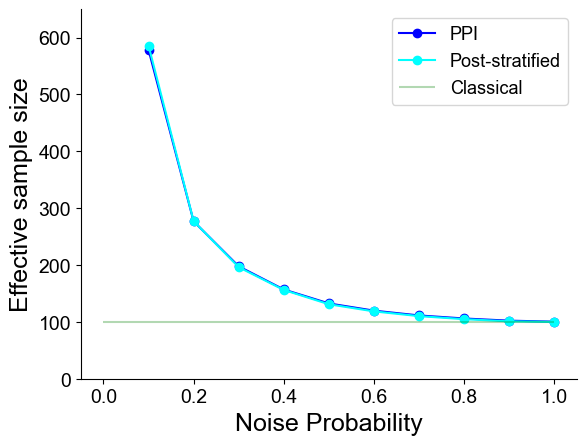

In [11]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ppi_effective_sample_sizes = 100*(classical_avg_width**2)/(np.array(ppi_avg_widths)**2)
plt.plot(probabilities[1:], ppi_effective_sample_sizes[1:], '-bo', label='PPI')

post_stratified_effective_sample_sizes = 100*(classical_avg_width**2)/(np.array(post_stratified_avg_widths)**2)
plt.plot(probabilities[1:], post_stratified_effective_sample_sizes[1:], '-o', color='cyan', label='Post-stratified')

plt.hlines(100, 0, 1, color='green', alpha=0.3, label='Classical')

plt.xlabel("Noise Probability")
plt.ylabel("Effective sample size")
plt.ylim([0, 650])
plt.legend()
plt.savefig('output_images/corn_fraction_noise_effective_sample_size.png', dpi=300, bbox_inches='tight')
plt.show()

# Experiments: Adding Bias

We define adding bias p to the map
product as resampling each of the 100000 map product points with probability 0.4 from the Bernoulli(p)
distribution. In other words, about 40% of the points are randomly labeled, while the remaining 60% points
are unchanged. Each resampled point is labeled as maize with probability p and non-maize with probability
1 − p. We experiment with bias values p from 0 to 1 at increments of 0.1. When p = 0.35, this does not add
bias, but as p ranges farther from 0.35, the amount of bias increases.

We also compute the map model accuracy (fraction of map product points whose values remain correct) at each bias level.

We compute the confidence intervals and average over 100 trials, where n=100 ground truth points are randomly chosen on each trial.

In [13]:
# Add bias to ML model (resample with probability 0.4, from a distribution with probability p of being corn)
probabilities = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
model_accuracies = []
ppi_avg_estimates = []
ppi_avg_widths = []
post_stratified_avg_estimates = []
post_stratified_avg_widths = []
map_only_estimates = []
map_only_widths = []

for p in probabilities:
    bias_mask = np.array(np.random.RandomState(seed=int(10*p)).choice([0,1], p=[0.6, 0.4], size = Y_total.shape[0]))
    random_labels = np.array(np.random.RandomState(seed=42).choice([0, 1], p=[1-p, p], size=Y_total.shape[0]))
    biased_Yhat_total = Y_total*(1-bias_mask) + random_labels*bias_mask
    model_accuracy = (Y_total==biased_Yhat_total).sum() / Y_total.size
    model_accuracies.append(model_accuracy)

    df = run_ppi(Y_total, biased_Yhat_total, ns=np.array([100]), num_trials=100, alpha=0.05)
    
    ppi_results = df.loc[(df['method'] == 'PPI') & (df['n'] == 100)]
    ppi_avg_estimates.append(ppi_results['estimate'].mean())
    ppi_avg_widths.append(ppi_results['width'].mean())
    
    classical_results = df.loc[(df['method'] == 'Classical') & (df['n'] == 100)]
    classical_avg_estimate = classical_results['estimate'].mean()
    classical_avg_width = classical_results['width'].mean()
    
    post_stratified_results = df.loc[(df['method'] == 'Post-stratified') & (df['n'] == 100)]
    post_stratified_avg_estimates.append(post_stratified_results['estimate'].mean())
    post_stratified_avg_widths.append(post_stratified_results['width'].mean())
    
    map_only_estimates.append(df.loc[df['method']=='Map-only']['estimate'].mean())
    map_only_widths.append(df.loc[df['method']=='Map-only']['width'].mean())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


Visualize estimated maize fraction at different bias levels

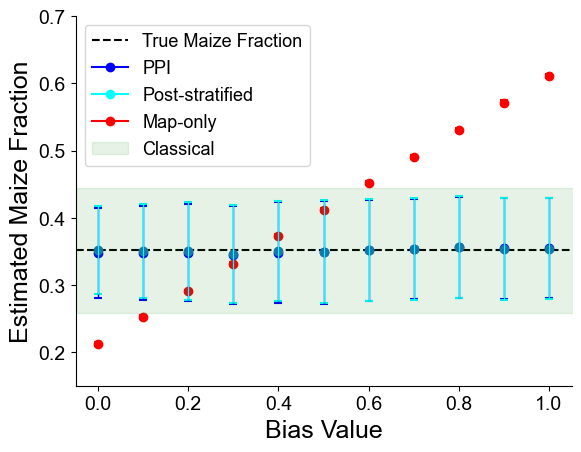

In [14]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Post-stratified')
plt.plot([], '-o', color='red', label='Map-only')

plt.scatter(probabilities, ppi_avg_estimates, color='blue')
plt.scatter(probabilities, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(probabilities, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(probabilities, post_stratified_avg_estimates)
plt.scatter(probabilities, post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
plt.scatter(probabilities, post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(probabilities):
    ymin = (post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2)[i]
    ymax = (post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(probabilities, map_only_estimates, color='red')
plt.scatter(probabilities, map_only_estimates-np.array(map_only_widths)/2, color='red', marker='_')
plt.scatter(probabilities, map_only_estimates+np.array(map_only_widths)/2, color='red', marker='_')

plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.legend()
plt.xlim([-0.05, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Bias Value")
plt.savefig('output_images/corn_fraction_bias.png', dpi=300, bbox_inches='tight')
plt.show()

Visualize estimated maize fraction at different model accuracies (from varying bias levels)

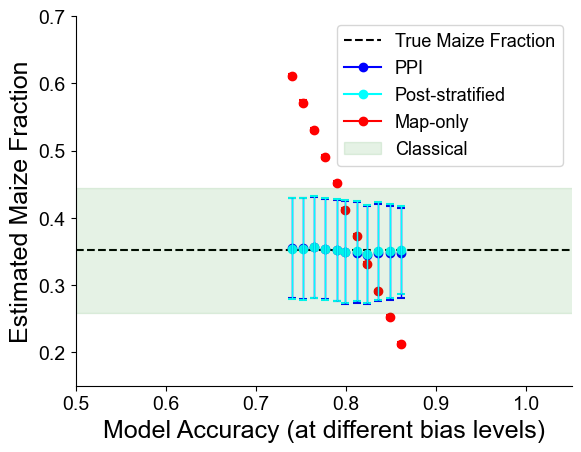

In [15]:
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axhline(true_theta, color ='black', linestyle='--', label='True Maize Fraction', zorder=0)

plt.plot([], '-o', color='blue', label='PPI')
plt.plot([], '-o', color='cyan', label='Post-stratified')
plt.plot([], '-o', color='red', label='Map-only')

plt.scatter(model_accuracies, ppi_avg_estimates, color='blue')
plt.scatter(model_accuracies, ppi_avg_estimates-np.array(ppi_avg_widths)/2, color='blue', marker='_')
plt.scatter(model_accuracies, ppi_avg_estimates+np.array(ppi_avg_widths)/2, color='blue', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (ppi_avg_estimates-np.array(ppi_avg_widths)/2)[i]
    ymax = (ppi_avg_estimates+np.array(ppi_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="blue", linewidth=1)
    
plt.scatter(model_accuracies, post_stratified_avg_estimates, color='cyan')
plt.scatter(model_accuracies, post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
plt.scatter(model_accuracies, post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2, color='cyan', marker='_')
for i, prob in enumerate(model_accuracies):
    ymin = (post_stratified_avg_estimates-np.array(post_stratified_avg_widths)/2)[i]
    ymax = (post_stratified_avg_estimates+np.array(post_stratified_avg_widths)/2)[i]
    ax.vlines(x=prob, ymin=ymin, ymax=ymax, color="cyan", linewidth=1)

plt.scatter(model_accuracies, map_only_estimates, color='red')
plt.scatter(model_accuracies, map_only_estimates-np.array(map_only_widths)/2, color='red', marker='_')
plt.scatter(model_accuracies, map_only_estimates+np.array(map_only_widths)/2, color='red', marker='_')

plt.fill_between(np.arange(-0.05, 1.2, 0.1), classical_avg_estimate-classical_avg_width/2, classical_avg_estimate+classical_avg_width/2, color='green', alpha=0.1, label='Classical')

plt.legend()
plt.xlim([0.5, 1.05])
plt.ylim([0.15, 0.7])
#plt.title("Corn Fraction Confidence Intervals")
plt.ylabel("Estimated Maize Fraction")
plt.xlabel("Model Accuracy (at different bias levels)")
plt.savefig('output_images/corn_fraction_bias_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()